# Imports
Import all required libraries for data processing, modeling, and visualization.

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xarray as xr


# 1. Data Loading and Train and Test Dataset
Load two dataset (train + test) and split into features (X) and targets (Y).

In [26]:
def get_data_MLP(ds, predicted_horizon=1, n_data=1000):
    # Dataset as an Array (Regarding the Features Selected)
    Xs = ds[["u10", "v10", "d2m", "t2m", "msl", "sst", "skt", "sp", "ssrd", "strd", "tp", "mwd", "mwp", "swh"]].to_array().values


    #from hiperparameters using to creat the encoder:
    neigh_lat=1
    neigh_lon=1
    time_horizon=2
    
    from GetData import get_train_data
    list_data, list_index = get_train_data(ds, Xs, n_data, neigh_lat, neigh_lon, time_horizon+predicted_horizon)
    data = np.array(list_data)  # Flatten and reshape for scaler
    print(f"Data shape before tensor conversion: {data.shape}")
    D = torch.tensor(data, dtype=torch.float32)
    # should be (num_central_points, 11 * ((3*3)*(2+1)) = 11 * 27 = 297)
    
    X = D[:, 0:2*9*14] # Input data t-1 and t-2
    Y = D[:, 2*9*14-3:2*9*14]  # Target data at t (train and test) --> goal
    
    

    return X, Y
    

Use get_data_MLP to get both train and test sets

In [27]:
# --------------------- LOAD DATASET ---------------------
folder = "dataset_train"
ds = xr.open_dataset(f"{folder}/combined.nc")
Xtr, ytr = get_data_MLP(ds, predicted_horizon=1, n_data=8000)


folder = "dataset_test"
ds = xr.open_dataset(f"{folder}/combined.nc")
Xte, yte= get_data_MLP(ds, predicted_horizon=1, n_data=2000)

print(f"Training data shape of input: {Xtr.shape}, target: {ytr.shape}")
print(f"Testing data shape of input: {Xte.shape}, target: {yte.shape}")

target_dim = ytr.shape[1]  # Number of target variables (e.g., 3 for mwp, mwd, swh)
print(f"Target dimension: {target_dim}")

Progress: |==============================| 8000/8000 (100.0%)Data shape before tensor conversion: (8000, 378)
Progress: |==============================| 2000/2000 (100.0%)Data shape before tensor conversion: (2000, 378)
Training data shape of input: torch.Size([8000, 252]), target: torch.Size([8000, 3])
Testing data shape of input: torch.Size([2000, 252]), target: torch.Size([2000, 3])
Target dimension: 3


# 2. Data Scaling
Scale both input features and targets for better training.
- **Input variables**: Scaled using "model/scaler.save", previous obtained in "2. Auto_encoder.ipynb" file
- **Target Variables**: New Standard Scale used

In [28]:
# Load scaler
import joblib
scaler = joblib.load("model/scaler.save")

# Transform train and test data before encoding
Xtr_scaled = torch.tensor(scaler.transform(Xtr), dtype=torch.float32)
Xte_scaled = torch.tensor(scaler.transform(Xte), dtype=torch.float32)


scaler_y = StandardScaler()
ytr_scaled = scaler_y.fit_transform(ytr.reshape(-1, target_dim))
yte_scaled = scaler_y.transform(yte.reshape(-1, target_dim))
print(f"ytr_scaled shape: {ytr_scaled.shape}, yte_scaled shape: {yte_scaled.shape}")

ytr_scaled shape: (8000, 3), yte_scaled shape: (2000, 3)


# 3. Data Encoding
Same Autoencoder arquitecture as the one trained in "2. Auto_encoder.ipynb"

In [29]:
#Define your Autoencoder class if not already defined
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoded_size=64):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoded_size, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Load the model and encode the train and test data used as input

In [30]:
# Load the trained autoencoder model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(input_size=Xtr_scaled.shape[1], encoded_size=32).to(device)
autoencoder.load_state_dict(torch.load("model/autoencoder_model.pth", map_location=device))
autoencoder.eval()

print("Before Encoding", Xtr.shape , Xte.shape )
with torch.no_grad():
    Xtr_encoded = autoencoder.encoder(Xtr_scaled.to(device)).cpu()
    Xte_encoded = autoencoder.encoder(Xte_scaled.to(device)).cpu()
    print("After Encoding:", Xtr_encoded.shape , Xte_encoded.shape )

Before Encoding torch.Size([8000, 252]) torch.Size([2000, 252])
After Encoding: torch.Size([8000, 32]) torch.Size([2000, 32])


C:\Users\berna\AppData\Local\Temp\ipykernel_19732\299230587.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("model/autoencoder_mod

# 4. MLP Model Definition
Definition of MLP architecture.

In [31]:
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, output_dim)
        )
    def forward(self, x):
        return self.model(x)

# Model parameters
INPUT_DIM = Xtr_scaled.shape[1]  # 252
OUTPUT_DIM = target_dim  # 3


print(f"Model MLP Architecture:")
print(f"Input dimension: {INPUT_DIM}")
print(f"Output dimension: {OUTPUT_DIM}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp = ImprovedMLP(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM).to(device)


Model MLP Architecture:
Input dimension: 252
Output dimension: 3


# 5. Model Training 
**Setup** - Prepare data loaders, loss function, and optimizer.

In [32]:
batch_size = 64
train_loader = DataLoader(TensorDataset(torch.tensor(Xtr_scaled, dtype=torch.float32), torch.tensor(ytr_scaled, dtype=torch.float32)), batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

C:\Users\berna\AppData\Local\Temp\ipykernel_19732\1274960706.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loader = DataLoader(TensorDataset(torch.tensor(Xtr_scaled, dtype=torch.float32), torch.tensor(ytr_scaled, dtype=torch.float32)), batch_size=batch_size, shuffle=True)


**Training Loop** - Train the MLP and monitor training loss

In [33]:
num_epochs = 50
for epoch in range(num_epochs):
    mlp.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = mlp(xb).squeeze()
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    mlp.eval()

# 6. Prediction and Inverse Scaling
Make predictions and convert them back to the original scale.

In [34]:
with torch.no_grad():
    y_pred_scaled = mlp(torch.tensor(Xte_scaled, dtype=torch.float32).to(device)).cpu().numpy().flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, target_dim))
y_true = scaler_y.inverse_transform(yte_scaled.reshape(-1, target_dim))

C:\Users\berna\AppData\Local\Temp\ipykernel_19732\3081011284.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_scaled = mlp(torch.tensor(Xte_scaled, dtype=torch.float32).to(device)).cpu().numpy().flatten()


# 7. Evaluation and Visualization
Plot predictions vs. true values and check distribution.

C:\Users\berna\AppData\Local\Temp\ipykernel_19732\1112919791.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  yte = np.array(yte)



--- Target: mwd ---
Mean Squared Error (MSE): 100.7217
Mean Absolute Error (MAE): 7.8430
Normalized MAE (NMAE): 0.0218


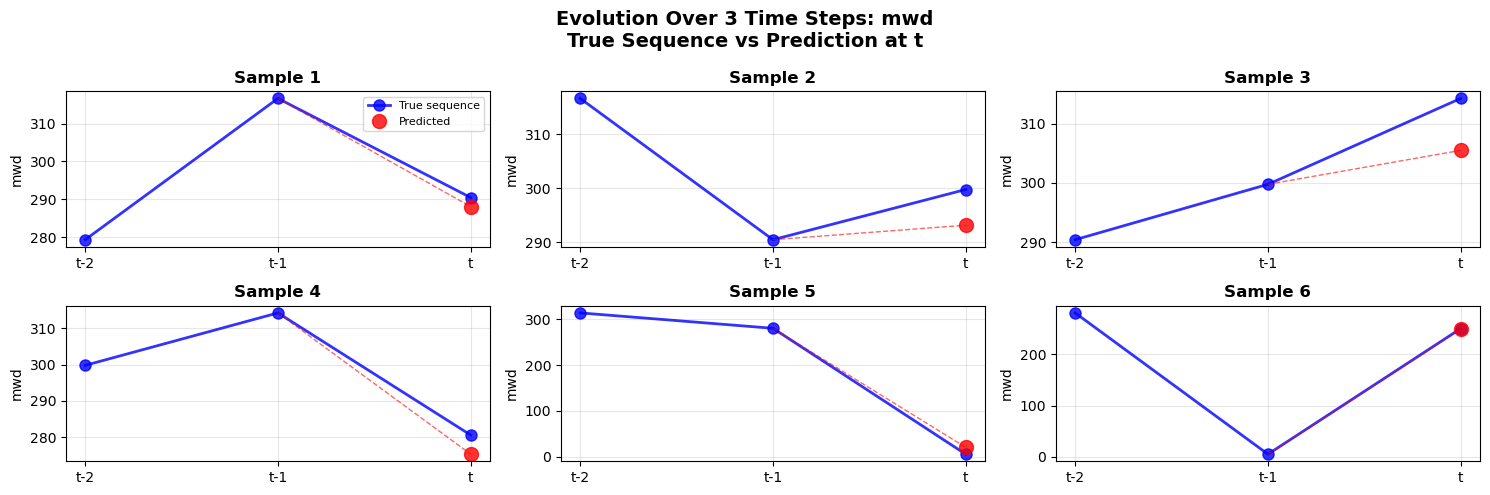

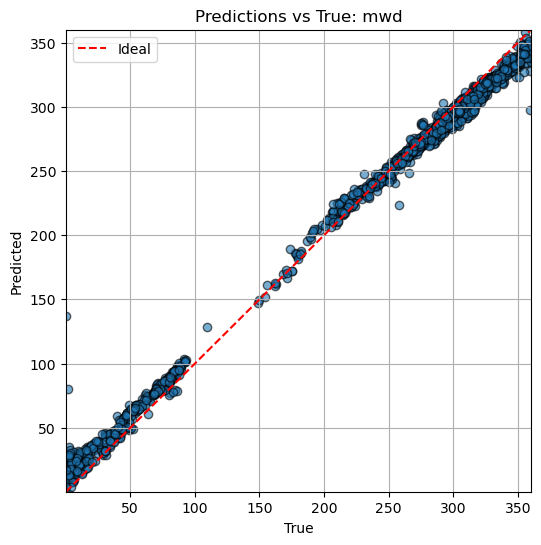

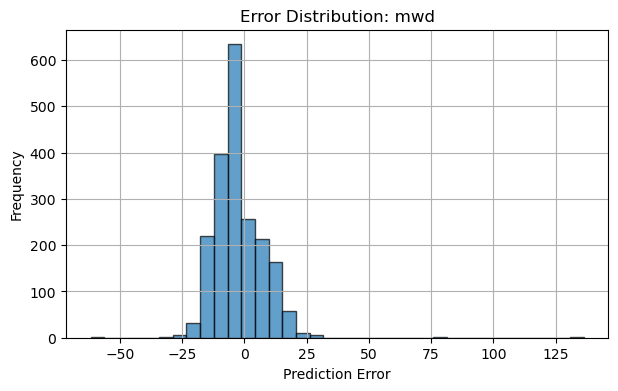


--- Target: mwp ---
Mean Squared Error (MSE): 0.0597
Mean Absolute Error (MAE): 0.1929
Normalized MAE (NMAE): 0.0217


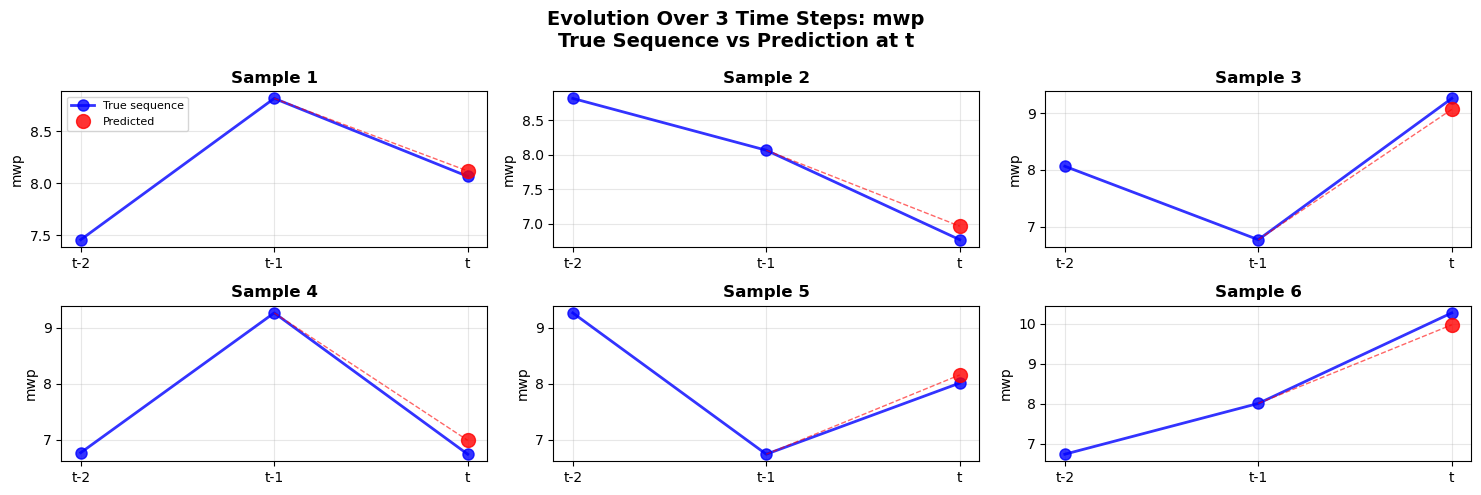

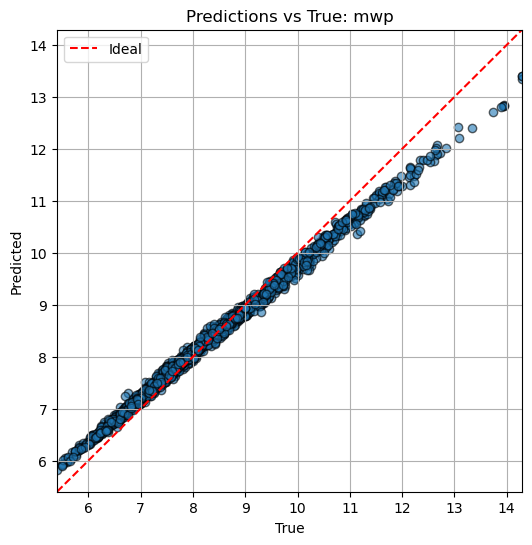

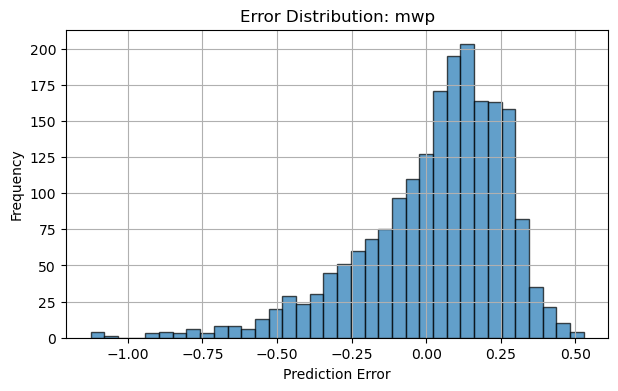


--- Target: swh ---
Mean Squared Error (MSE): 0.0454
Mean Absolute Error (MAE): 0.1853
Normalized MAE (NMAE): 0.0253


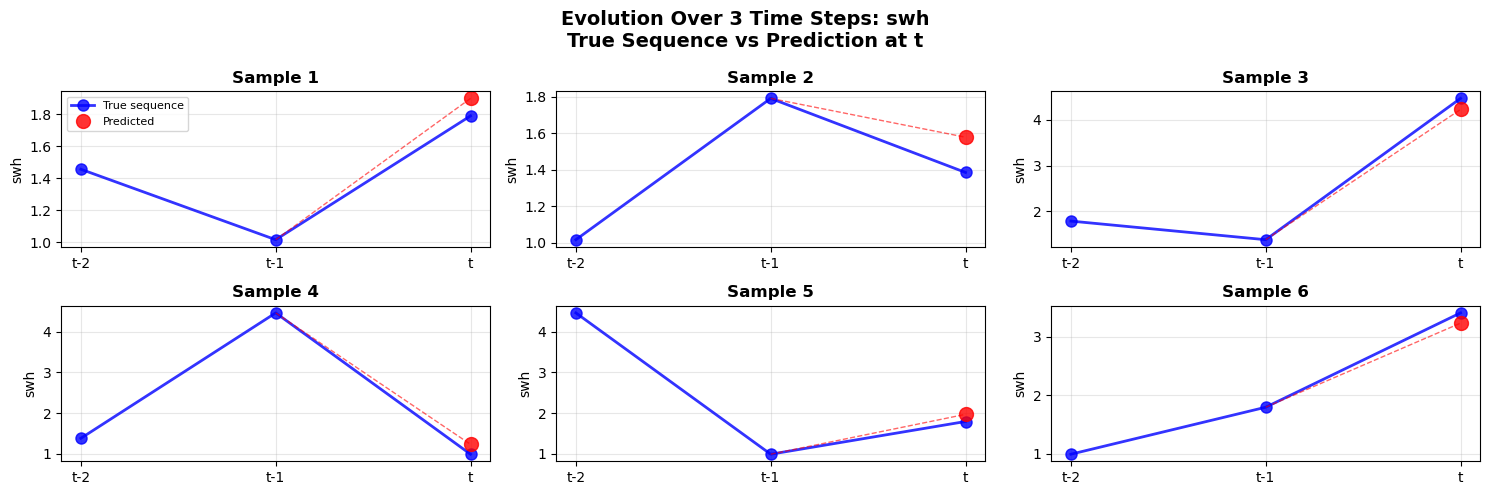

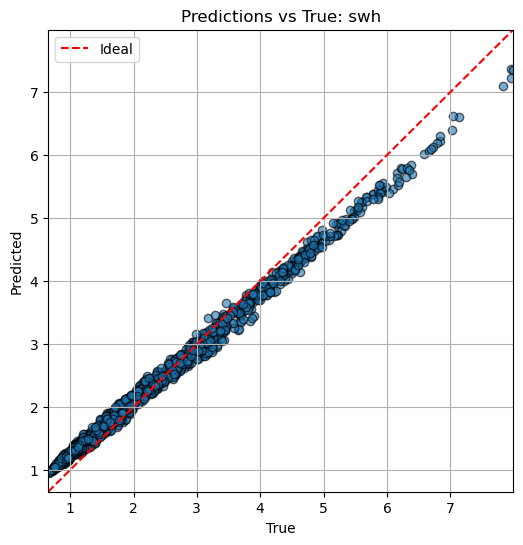

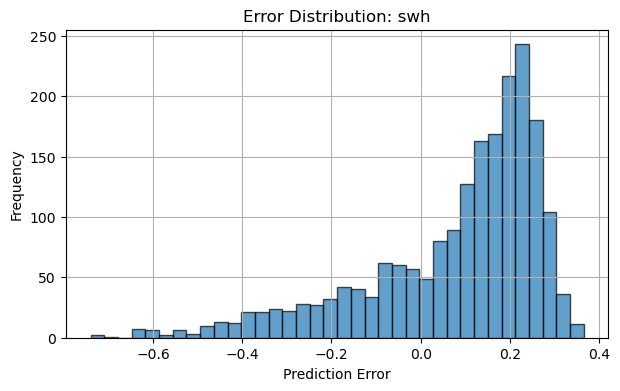

In [35]:
# Convert to numpy arrays if needed
yte = np.array(yte)
y_pred = np.array(y_pred)

def angular_error(y_true, y_pred):
    return ((y_pred - y_true + 180) % 360) - 180

#target_names = ["mwp"]  # Adjust names as needed
target_names = ["mwd", "mwp", "swh"]
#target_names = ["u10", "v10", "d2m", "t2m", "msl", "sst", "skt", "sp", "ssrd", "strd", "tp", "mwd", "mwp", "swh"]

for i in range(yte.shape[1]):
    print(f"\n--- Target: {target_names[i]} ---")
    yte_i = yte[:, i]
    y_pred_i = y_pred[:, i]
    errors = angular_error(yte_i, y_pred_i)
    mse = np.mean(errors**2)
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {np.mean(np.abs(errors)):.4f}")
    print(f"Normalized MAE (NMAE): {np.mean(np.abs(errors)) / (np.max(yte_i) - np.min(yte_i)):.4f}")

    #----------------------------------Evolution over the 3 time steps----------------------------------
    plt.figure(figsize=(15, 5))
    
    # Select first 6 samples for visualization
    n_samples_plot = min(6, len(yte_i))
    
    for sample_idx in range(n_samples_plot):
        plt.subplot(2, 3, sample_idx + 1)
        
        # Use yte as the 3 consecutive real values (assuming they represent t-2, t-1, t)
        # For simplicity, we'll create a pattern where each sample shows evolution
        if sample_idx < len(yte_i) - 2:
            # Use 3 consecutive values from yte as historical sequence
            historical_values = [
                yte_i[sample_idx],      # t-2
                yte_i[sample_idx + 1],  # t-1  
                yte_i[sample_idx + 2]   # t (true)
            ]
            predicted_value = y_pred_i[sample_idx + 2]  # prediction for time t
        else:
            # For last samples, use different indices
            base_idx = sample_idx * 3 % (len(yte_i) - 2)
            historical_values = [
                yte_i[base_idx],
                yte_i[base_idx + 1],
                yte_i[base_idx + 2]
            ]
            predicted_value = y_pred_i[base_idx + 2]
        
        time_steps = ['t-2', 't-1', 't']
        
        # Plot historical evolution (3 consecutive true values)
        plt.plot(time_steps, historical_values, 'o-', color='blue', linewidth=2, 
                markersize=8, label='True sequence', alpha=0.8)
        
        # Add predicted point at time t
        plt.plot('t', predicted_value, 'o', color='red', 
                markersize=10, label='Predicted', alpha=0.8)
        
        # Connect t-1 to prediction with dashed line
        plt.plot(['t-1', 't'], [historical_values[1], predicted_value], 
                '--', color='red', linewidth=1, alpha=0.6)
        
        plt.title(f'Sample {sample_idx + 1}', fontsize=12, fontweight='bold')
        plt.ylabel(f'{target_names[i]}', fontsize=10)
        plt.grid(True, alpha=0.3)
        
        if sample_idx == 0:
            plt.legend(fontsize=8)
    
    plt.suptitle(f'Evolution Over 3 Time Steps: {target_names[i]}\n' +
                 f'True Sequence vs Prediction at t', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    


    # --------------------------------------- Scatter plot -------------------------------------------
    plt.figure(figsize=(6, 6))
    plt.scatter(yte_i, y_pred_i, alpha=0.6, edgecolor='k')
    plt.plot([min(yte_i), max(yte_i)], [min(yte_i), max(yte_i)], 'r--', label='Ideal')
    plt.xlim(min(yte_i), max(yte_i))
    plt.ylim(min(yte_i), max(yte_i))
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"Predictions vs True: {target_names[i]}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # -------------------------------------Error histogram-------------------------------------
    plt.figure(figsize=(7, 4))
    plt.hist(errors, bins=36, alpha=0.7, edgecolor='k')
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.title(f"Error Distribution: {target_names[i]}")
    plt.grid(True)
    plt.show()